# Study - Anomaly Detection 

-----------------------------------------
## Context
-----------------------------------------

Study of the ambient temperature in an office settings.

-----------------------------------------
## Objective
-----------------------------------------

To identify any anomaly detected in the dataset and build a model which can predict any anomaly to happen in future.

------------------------
## Data Dictionary
-------------------------
The data has the following attributes:
- timestamp: date and time format to capture the occurrence of event
- value: temperature in Fahrenheit

In the dataset, we will not do clustering on the timestamp and would rather try to understand pattern in temperature to guess anomaly in future occurrence.

## Importing libraries and overview of the dataset

In [209]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import dates as mpl_dates

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#importing classification algorithms
from sklearn.ensemble import IsolationForest

#importing TSNE
from sklearn.manifold import TSNE

#Silhouette score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

#### Loading dataset

In [25]:
data = pd.read_csv("NAB.csv")
data.head()

,timestamp,value
0,2013-07-04 0:00:00,69.880835
1,2013-07-04 1:00:00,71.220227
2,2013-07-04 2:00:00,70.877805
3,2013-07-04 3:00:00,68.959400
4,2013-07-04 4:00:00,69.283551


**Question 1:**

- Explore - Explain the shape and characteristic of the data. Use any visuals you see fit to explain the shape of the data. Anything interesting you observe? Any other insights you discovered? What other types of exploratory analysis would you like to do?

#### Check the information in dataset

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


**Observations:**
 
 - There are 7267 observations and 2 columns in the data.
 - All columns have 7267 non-null values i.e. there are no missing values.
 - Everything looks great, lets move ahead to check duplicates.

In [27]:
data[data.duplicated()]

,timestamp,value


- There are no duplicate rows in the data. That's good. 

## Exploratory Data Analysis

#### Summary Statistics

In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
value,7267.0,71.242433,4.247509,57.458406,68.369411,71.858493,74.430958,86.223213


**Observations:**

- The temperature has a high range from 57.45 to 86.22 Fahrenheit. The average temperature is approx 71.24 and median is 71.85. 
- Since the mean and median are very close to each other, this can be approximated as normal distribution.

#### Let's check the distribution and outliers for each column in the data

value
Skew : -0.39


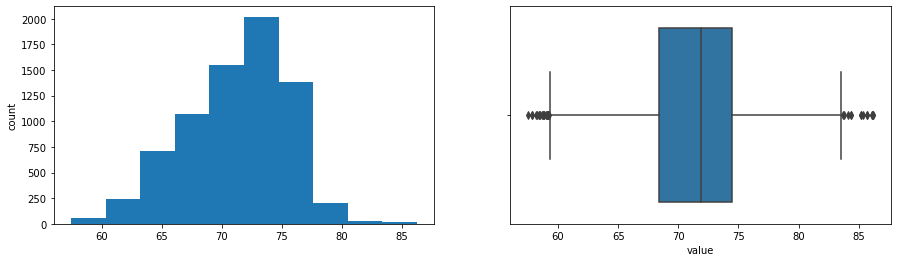

In [29]:
for col in data.columns[1:]:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- As observed earlier, most of the values for temperature have normal distributions
- There are few outliers as shown by the box plot, which is the anomaly of interest for us. 

**Question 2:**

- Feature Engineering - What features would you like to build to extend the data set? Extend your data set with these new features you identified in the previous step. Explore your newly transformed data now. Anything interesting you observe?

In [30]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = pd.DatetimeIndex(data['timestamp']).month
data['year'] = pd.DatetimeIndex(data['timestamp']).year
data['day'] = pd.DatetimeIndex(data['timestamp']).day
data['hour'] = pd.DatetimeIndex(data['timestamp']).hour
data.head()

,timestamp,value,month,year,day,hour
0,2013-07-04 00:00:00,69.880835,7,2013,4,0
1,2013-07-04 01:00:00,71.220227,7,2013,4,1
2,2013-07-04 02:00:00,70.877805,7,2013,4,2
3,2013-07-04 03:00:00,68.959400,7,2013,4,3
4,2013-07-04 04:00:00,69.283551,7,2013,4,4


**Observations: Feature Engineering**

- As observed, created new features like year, month, day and hour.
- There is no outlier in the timestamp, so the engineered feature will also won't show any outlier pattern.
- We are provided with 2013 and 2014 datasets.

value
Skew : -0.39


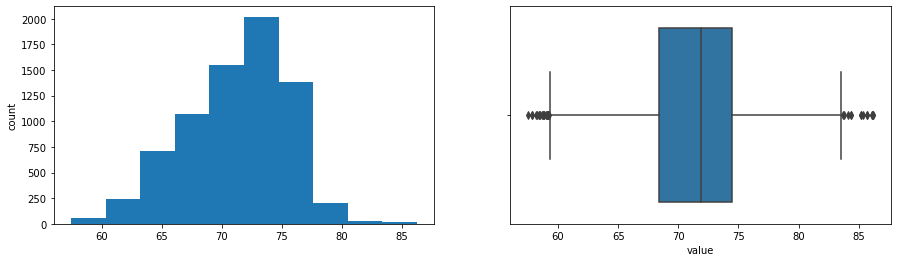

month
Skew : -0.03


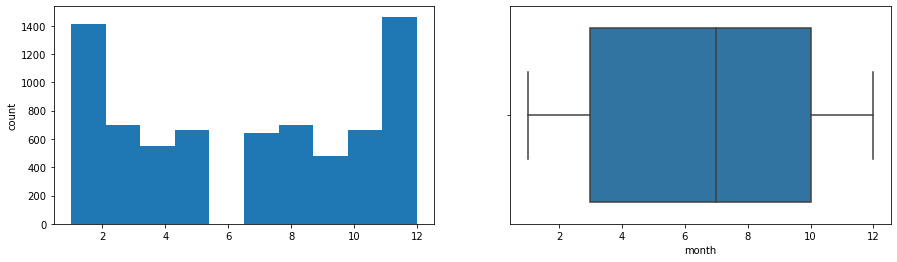

year
Skew : 0.17


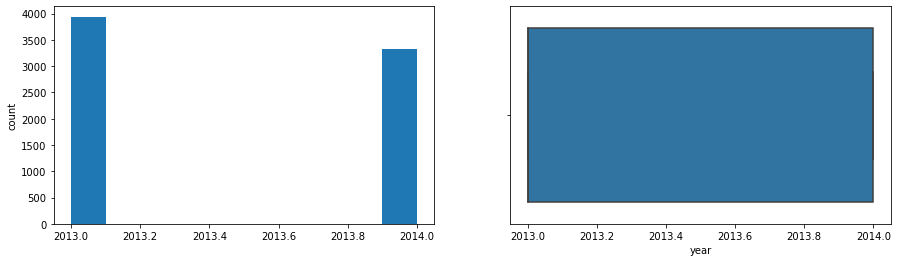

day
Skew : -0.04


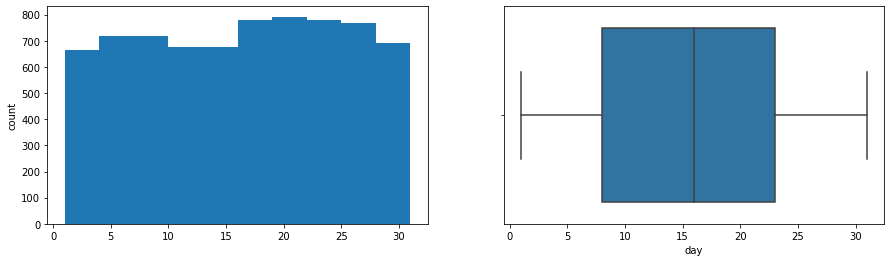

hour
Skew : -0.0


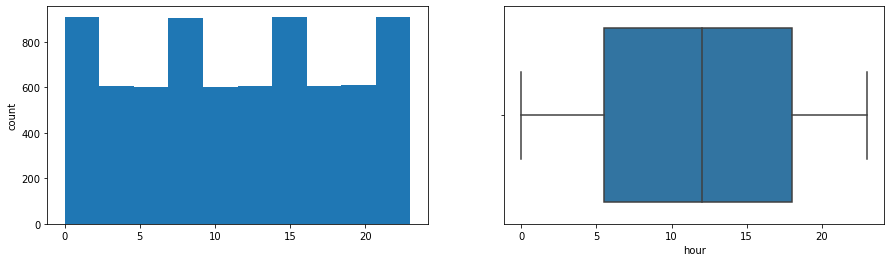

In [31]:
for col in data.columns[1:]:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Outliers can only be associated with temperature.

**Let's check the correlation among the variables**

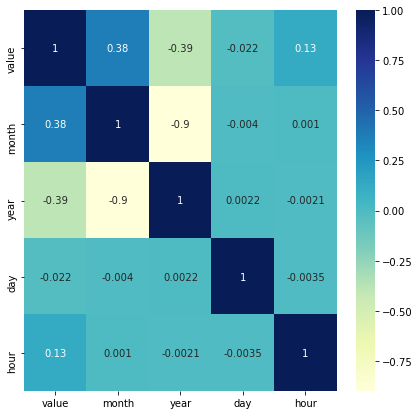

In [32]:
plt.figure(figsize  = (7,7))
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

**Observations:**

- There is a strong positive correlation between month and temperature. This makes sense as the month represents seasons. 
- With year, there is negative correlation with temperature. This explanation can't be explained by the current datasets and we need to look for external dataset [Also study more the source of the data provided].
- For others, there is no significant strong positive or negative correlation.

**Question 3** 

- Anomaly Detection - Statistical Model - Any statistical model you can identify to find outliers?

#### Scaling the data

- Clustering algorithms are distance based algorithms and all distance based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering algorithms.
- We will drop the variables `'timestamp'` before scaling the data as we would not use this variable for clustering the data points.

In [63]:
data_new = data.drop(columns=["timestamp"])

**Statistical Approach**

Point Anomalies : Percentiles
If an individual data instance can be considered as anomalous with respect to the rest of the data (e.g. purchase with large transaction value)

In [64]:
data_new[['value']].quantile([0.0, .005, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, .90, .95, 0.99, 0.995, 1.0])

,value
0.000,57.458406
0.005,59.910374
0.010,60.847064
0.050,63.660091
0.100,65.126804
0.250,68.369411
0.500,71.858493
0.750,74.430958
0.900,76.130217
0.950,77.034918


**Observations:**

- For Point Anomaly assumption, we can consider temperature value less than 60 (Less than 1%) and greater than 80 (greater than 99%) to be anomaly. 
- This shows that observing pattern using visualization is dependent on the data.

In [65]:
# Let's assign points to 4 different groups
def grouping(x):
    first_component = x['value']
    second_component = x['value']
    if second_component > 80:
        return 'group_1'
    elif (second_component <= 80) and (first_component >= 60): 
        return 'group_2'
    else:
        return 'group_3'

In [66]:
data_new['groups'] = data_new.apply(grouping, axis=1)

In [67]:
data_new.groupby(by=["groups"], dropna=False).mean()

,value,month,year,day,hour
groups,,,,,
group_1,82.356655,11.241379,2013.068966,21.827586,10.879310
group_2,71.220143,6.513182,2013.457804,15.766913,11.519459
group_3,59.121651,4.350000,2014.000000,15.500000,10.600000


**Observations:**

- There is a clear distinction in months for group1, group2 and group3 as expected for seasonal pattern.
- Apart from that, day averages for group1 [showing higher temperature], shows some pattern of later days of month where as other seems reasonably around averages of 15.
- Hours shows no disntinction between the groups.

In [45]:
#Creating copy of the data to store labels from each algorithm
data_copy = data_new.copy(deep=True)
data_copy.drop(columns="groups", inplace=True)

In [46]:
#Scaling the data and storing the output as a new dataframe
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data_copy), columns=data_copy.columns)
data_scaled.head()

,value,month,year,day,hour
0,-0.320586,0.124589,-0.918667,-1.369251,-1.661537
1,-0.005228,0.124589,-0.918667,-1.369251,-1.517172
2,-0.085851,0.124589,-0.918667,-1.369251,-1.372807
3,-0.537536,0.124589,-0.918667,-1.369251,-1.228442
4,-0.461215,0.124589,-0.918667,-1.369251,-1.084077


#### t-SNE

Let's try to visualize the data using tSNE by reducing the number of dimensions to 2 and 3.

**2d visualization**

In [58]:
#Fitting TSNE with number of components equal to 2 
tsne = TSNE(n_components = 2, random_state=1)
data_tsne = tsne.fit_transform(data_scaled)

In [59]:
#Converting the embeddings to a dataframe
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2'])

<AxesSubplot:xlabel='X1', ylabel='X2'>

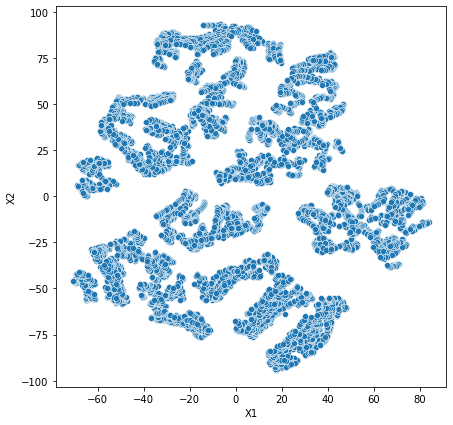

In [50]:
#Scatter plot for two components
plt.figure(figsize = (7,7))
sns.scatterplot(x = 'X1', y='X2', data = data_tsne)

**3d visualization**

In [51]:
#Fitting TSNE with number of components equal to 2 
tsne = TSNE(n_components = 3, random_state=1)
data_tsne = tsne.fit_transform(data_scaled)

In [52]:
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2', 'X3'])

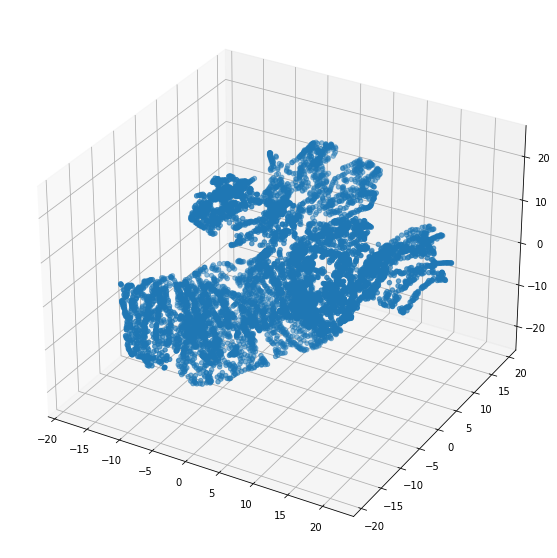

In [53]:
#Scatter plot for all three components
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

x = data_tsne['X1']
y = data_tsne['X2']
z = data_tsne['X3']

ax.scatter(x, y, z)

**Observations:**

- We know that tsne preserves the local structure of the data while embedding the data from high dimension to low dimension.
- Here, we have generated the 2D and 3D embeddings for the data. We can find no pattern in the data and it is scattered.
- Let's try different perplexity values to visualize the data in 2d.

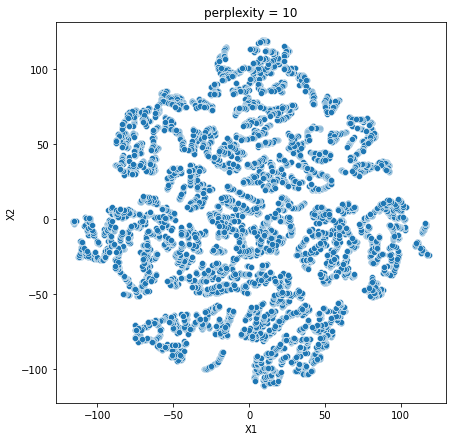

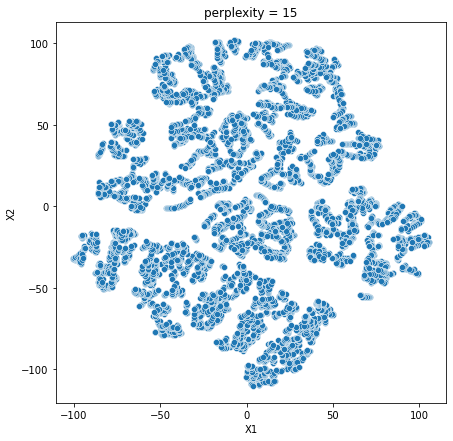

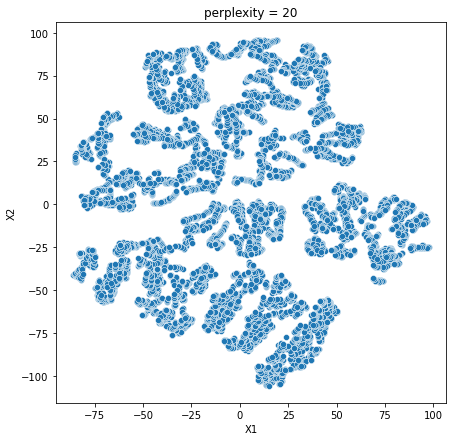

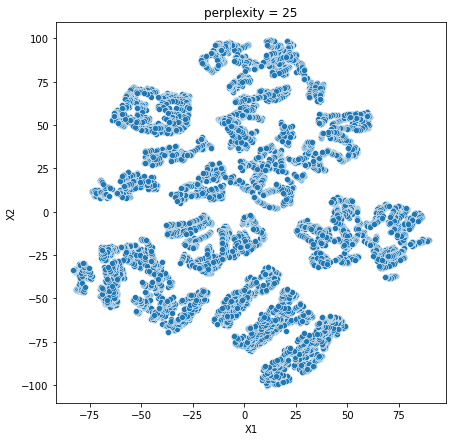

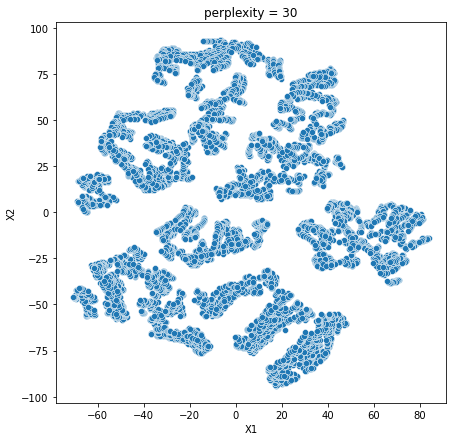

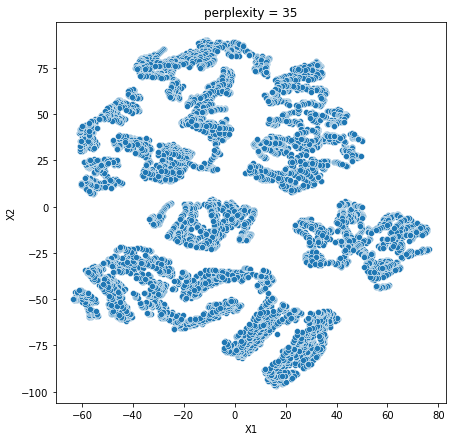

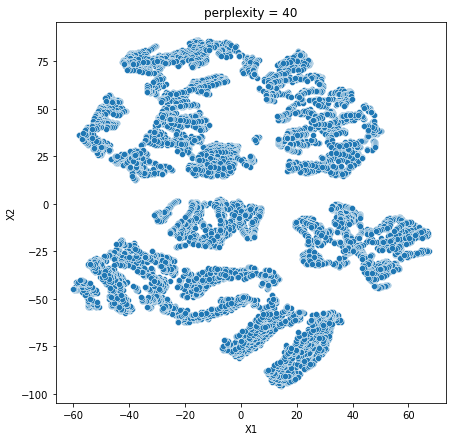

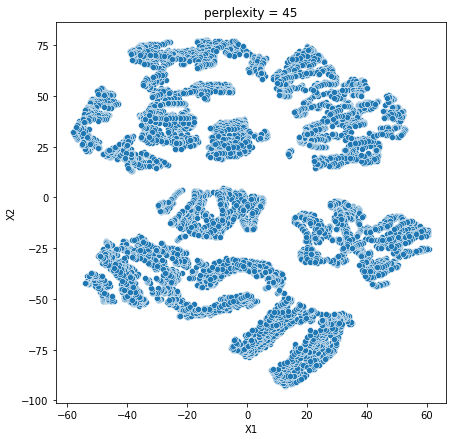

In [54]:
for i in range(10, 50, 5): 
    tsne = TSNE(n_components = 2, random_state=1, perplexity=i)
    data_tsne = tsne.fit_transform(data_scaled)
    data_tsne = pd.DataFrame(data_tsne)
    data_tsne.columns = ['X1', 'X2']
    plt.figure(figsize = (7,7))
    sns.scatterplot(x = 'X1', y='X2', data = data_tsne)
    plt.title("perplexity = {}".format(i))

**Observations:**

- All the plots with different perplexity values implies that there is no underlying pattern in the data.
- This shows that observing pattern using visualization is dependent on the data. 

**Question 4** 
- Anomaly Detection using Clustering - What clustering approach would you use to identify anomalies? Please share your results.

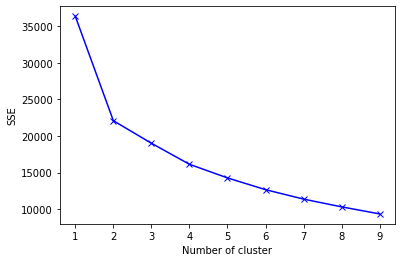

In [68]:
#Empty dictionary to store the SSE for each value of k
sse = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

#Elbow plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**Observations:**

- We can see from the plot that there is a consistent dip from 2 to 9 and there doesn't seem to be a clear 'elbow' here. We may chose any from 2 to 8 as our # of clusters. 
- So, let's look at another method to get a 'second opinion from maths'. Let's create a plot with Silhouette scores to see how it varies with k.

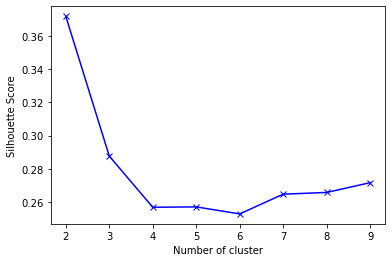

In [69]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

**Observations:**

- We can see from the plot that silhouette score is lowest for k=6. Well that makes it slightly easy for us and we can start with first understanding these 3 clusters. So let's take the number of clusters as 6.

In [89]:
kmeans = KMeans(n_clusters=6, random_state=1)

# Training the model here
kmeans.fit(data_scaled)

#Adding predicted labels to the original data and scaled data 
# Added a new label here [Scaled dataset]
data_scaled['KMeans_Labels'] = kmeans.predict(data_scaled)

# Labels : 
data_copy['KMeans_Labels'] = kmeans.predict(data_scaled)

In [90]:
data_copy['KMeans_Labels'].value_counts()

2    1672
0    1454
5    1434
3    1413
1    1240
4      54
Name: KMeans_Labels, dtype: int64

In [91]:
#Calculating mean and median of the original data for each label
mean = data_copy.groupby('KMeans_Labels').mean()
median = data_copy.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean','group_4 Mean', 'group_5 Mean','group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median', 'group_4 Median', 'group_5 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_4 Mean,group_5 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median,group_4 Median,group_5 Median
value,70.048601,65.216646,73.918245,72.245026,73.703122,73.463010,70.532926,65.42227,74.279318,72.251869,74.823849,73.425816
month,2.800550,4.973387,9.959928,3.936306,10.907407,10.094840,3.000000,5.00000,10.000000,2.000000,11.000000,10.000000
year,2014.000000,2013.734677,2013.000000,2013.678698,2013.037037,2013.000000,2014.000000,2014.00000,2013.000000,2014.000000,2013.000000,2013.000000
day,21.647180,15.560484,17.467703,7.263977,2.222222,17.126220,22.000000,16.00000,18.000000,6.000000,2.000000,18.000000
hour,14.531637,6.403226,17.735646,12.091295,10.259259,5.073919,15.000000,6.00000,18.000000,12.000000,11.000000,5.000000


#### Visualize Clusters

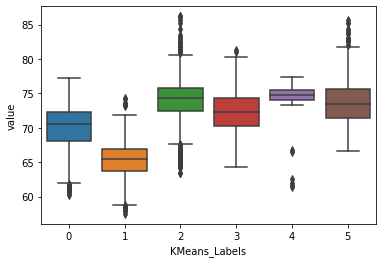

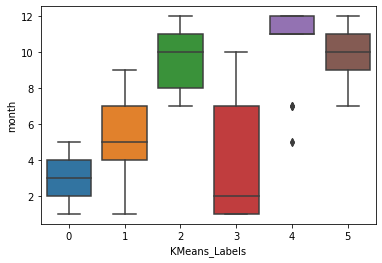

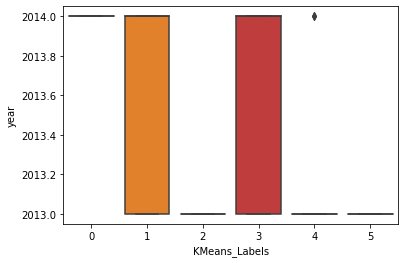

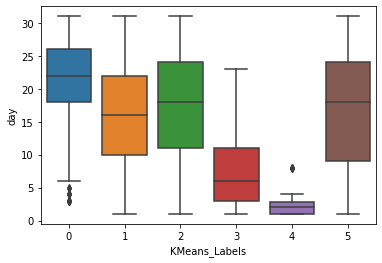

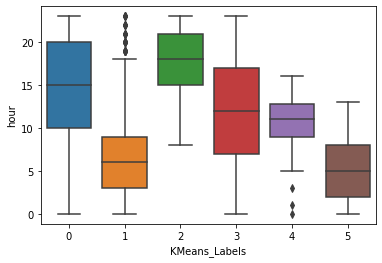

In [93]:
cols_visualise = ['value', 'month', 'year', 'day', 'hour']

for col in cols_visualise:
    sns.boxplot(x = 'KMeans_Labels', y = col, data = data_copy)
    plt.show()

**Cluster Profiles:**

- **Group 0** : **Initial** Months of the year + **Later** days of the Month + **Second** half of the day + Temperature around **70**
- **Group 1** : **Initial** Months of the year + **All** days of the Month + **Second** half of the day + Temperature around **65**
- **Group 2** : **Later** Months of the year   + **Later** days of the Month + **Second** half of the day + Temperature around **74**
- **Group 3** : **Initial** Months of the year + **Initial** days of the Month + **First** half of the day + Temperature around **72**
- **Group 4** : **Later** Months of the year + **Initial** days of the Month + **First** half of the day + Temperature around **74**
- **Group 5** : **Later** Months of the year + **Later** days of the Month + **Second** half of the day + Temperature around **73**

#### KNN : Moving to Classification Based Approach [Creating Anomaly Labels first]

KNN uses similar features to predict the values of new data points, which means the new data point will be assigned a value based on how similar it is to the data points in the training set. 


The following steps are performed in KNN:

- Select K
- Calculate distance (Euclidean, Manhattan, etc.)
- Find the K closest neighbors

The “K” in the KNN algorithm is the nearest neighbor we wish to take the vote from. Generally, K is taken to be an odd number when the no. of classes are even, so as to get a majority vote. Let's say K = 3. In that case, we will make a circle with the new data point as the center just as big as enclosing only the three nearest data points on the plane.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- We will go with 3 and 5 as number of classes we are looking for is anomaly vs non-anomaly data points.

In [ ]:
# Drop unnecessary columns
data_copy.drop(columns="year", inplace=True)

,value,month,day,hour,KMeans_Labels,outlier
0,69.880835,7,4,0,3,1
35,72.530563,7,5,11,3,1
71,67.163377,7,6,23,3,1
72,66.275684,7,7,0,1,1
76,66.750984,7,7,4,1,1


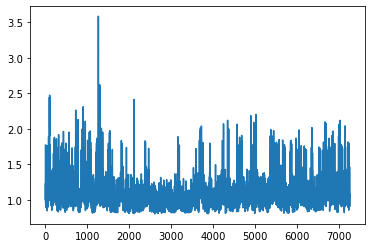

In [121]:
# instantiate model
nbrs = NearestNeighbors(n_neighbors = 5)

# fit model
nbrs.fit(data_copy)
         
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(data_copy)
         
# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

# visually determine cutoff values > 0.15
outlier_index = np.where(distances.mean(axis = 1) > 1.5)
outlier_index

# filter outlier values
outlier_values = data_copy.iloc[outlier_index]
outlier_values[:5]

In [117]:
# Setting Outliers
data_copy['outlier'] = 0
data_copy['outlier'].iloc[outlier_index] = 1

In [118]:
data_copy.head()

,value,month,day,hour,KMeans_Labels,outlier
0,69.880835,7,4,0,3,1
1,71.220227,7,4,1,3,0
2,70.877805,7,4,2,3,0
3,68.959400,7,4,3,3,0
4,69.283551,7,4,4,3,0


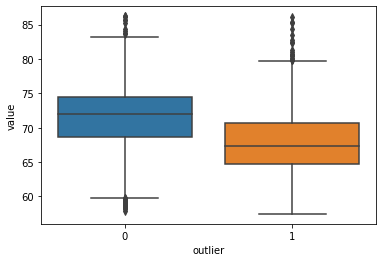

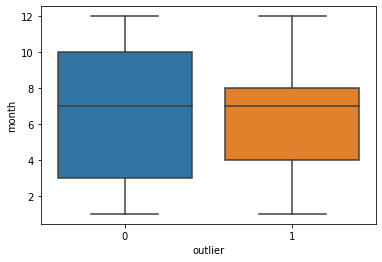

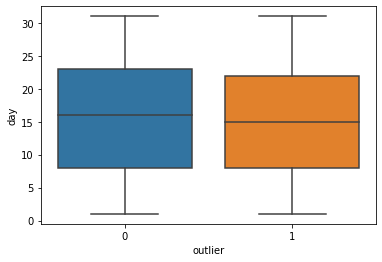

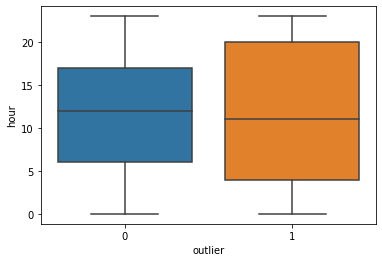

In [120]:
cols_visualise = ['value', 'month', 'day', 'hour']

for col in cols_visualise:
    sns.boxplot(x = 'outlier', y = col, data = data_copy)
    plt.show()

**Anomaly Profiles:**

- **Outlier** : Temperature around **68**
- **Normal** : Temperature around **74**

**Question 5** 
- Anomaly Detection using Classification - What classification approach would you use to identify anomalies? Please share your results.
- We will start with Isolation Forest Algorithm.

In [199]:
data = pd.read_csv("NAB.csv")

In [200]:
import datetime as dt
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = data['timestamp'].map(dt.datetime.toordinal)

In [201]:
#Isolation Forest Model Prediction
data_if = data.copy(deep=True)
model= IsolationForest(n_estimators=10)
model.fit(data_if)
data_pred = model.predict(data_if)
print("Valid cases Accuracy:", list(data_pred).count(1)/data_pred.shape[0])

Valid cases Accuracy: 0.6387780377046924


In [202]:
# Setting Outliers
data_if['anomaly'] = data_pred
data_if.head()

,timestamp,value,anomaly
0,735053,69.880835,-1
1,735053,71.220227,-1
2,735053,70.877805,-1
3,735053,68.959400,-1
4,735053,69.283551,-1


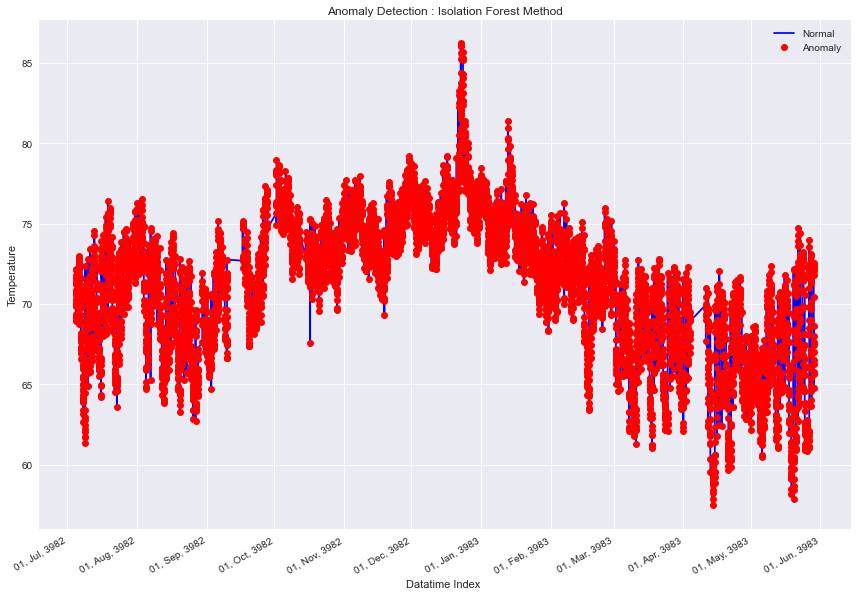

In [203]:

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(data_if['timestamp'],data_if['value'], color='blue', label = 'Normal')
plt.plot_date(x=data_if['timestamp'],y=data_if['value'], color='red', label = 'Anomaly')

#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Temperature")
plt.title('Anomaly Detection : Isolation Forest Method')
plt.legend()
plt.show()

In [204]:
data_if.groupby(by=["anomaly"], dropna=False).count()

,timestamp,value
anomaly,,
-1,2625,2625
1,4642,4642


#### One Class SVM

In [205]:
# train oneclassSVM
from sklearn.svm import OneClassSVM
data_oc = data.copy(deep=True)
model = OneClassSVM( kernel="rbf", gamma=0.01)
model.fit(data_oc)

OneClassSVM(gamma=0.01)

In [206]:
data_pred = model.predict(data_oc)
# Setting Outliers
data_oc['anomaly'] = data_pred
data_oc.head()

,timestamp,value,anomaly
0,735053,69.880835,-1
1,735053,71.220227,-1
2,735053,70.877805,-1
3,735053,68.959400,-1
4,735053,69.283551,-1


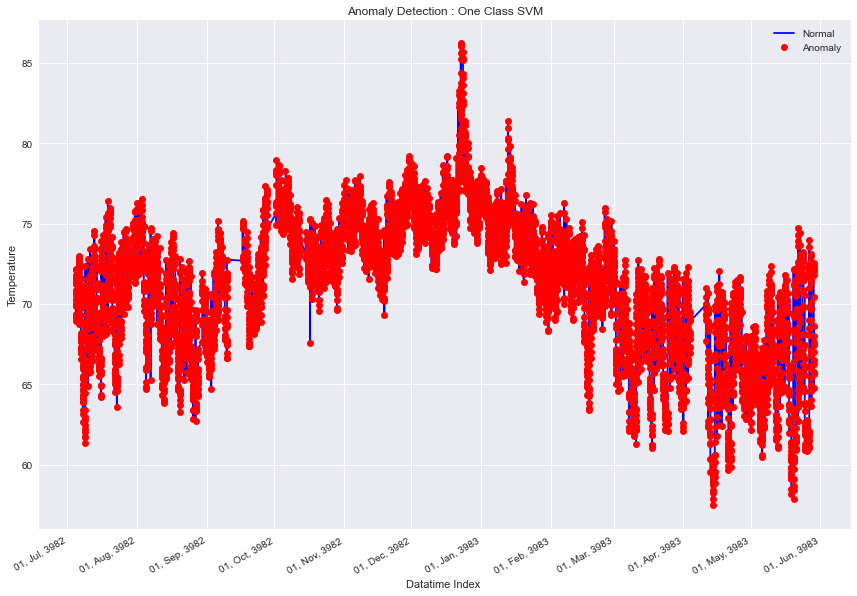

In [207]:
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(data_oc['timestamp'],data_oc['value'], color='blue', label = 'Normal')
plt.plot_date(x=data_oc['timestamp'],y=data_oc['value'], color='red', label = 'Anomaly')

#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Temperature")
plt.title('Anomaly Detection : One Class SVM')
plt.legend()
plt.show()

In [208]:
data_oc.groupby(by=["anomaly"], dropna=False).count()

,timestamp,value
anomaly,,
-1,3637,3637
1,3630,3630


### Conclusion

**Observations:**

- Firstly, we explored the data set using standard EDA processes and created visuals to understand outliers & inherent pattern in dataset more.
- We created new features as date, time, month and year to further analyze the dataset and validated the difference in temperature for those feature to check significance visually. 
- Anomaly Detection [Statistical Measures]: We understood the anomalies in dataset using means, standard deviations using box-plots and histograms.
- Anomaly Detection [Clustering]: We tried few clustering based unsupervised ML approaches like kmeans and t-SNE to find anomalies in dataset. 
- Anomaly Detection [Classification]: We also tried Unsupervised ML algorithms like Isolation Forest or One class SVM to find anomalies. 

- We ended up getting results from all and in order to validate the performance it is better to check with some business context and understand more what is defined as anomalies from business context.
